<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/04_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictions

In this notebook we're going to explore the citation dataset that we we imported in the previous notebook. As with the previous notebook let's install and import py2neo and pandas. We'll also install matplotlib to create some charts showing us the shape of the data.

In [ ]:
!pip install py2neo pandas matplotlib

And let's import those libraries:

In [1]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


Update the cell below with the same Sandbox credentials that you used in the first notebook:

In [2]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 

# graph = Graph("bolt://18.234.168.45:33679", auth=("neo4j", "daybreak-cosal-rumbles")) 
graph = Graph("bolt://3.17.177.63:7687", auth=("neo4j", "digityser"))

## What's in our database?

Now we can run the following query to check how many nodes our database contains:

When were the articles published?

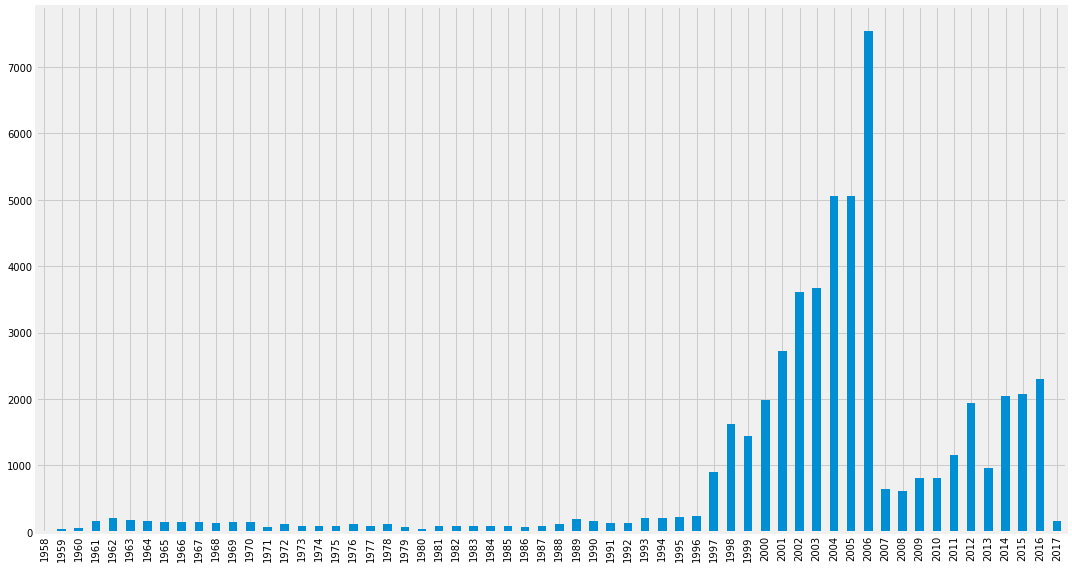

In [3]:
query = """
MATCH (article:Article) WHERE exists(article.year)
WITH article.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [4]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 465672
relationships_created: 155224
relationships_deleted: 0

In [5]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year < 2006
MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 243288
relationships_created: 81096
relationships_deleted: 0

In [6]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
WHERE year >= 2006
MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 222384
relationships_created: 74128
relationships_deleted: 0

In [4]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [5]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


In [6]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [7]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [8]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [11]:
training_df.sample(5)

,label,node1,node2
843032,0,209284,72287
1025000,1,150744,150745
58070,0,3368,150578
1029703,1,179089,179090
827046,0,201262,200726


In [12]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [13]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [14]:
test_df.head()

,label,node1,node2
1326656,1,175462,242658
1327564,1,243286,243288
1326776,1,242761,242764
899296,0,195736,71387
1201070,0,248543,11095


# Choosing a machine learning algorithm

We’ll create our machine learning pipeline based on a random forest classifier. This method is well suited as our data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure we don’t create a model that only fits our training data.

In [15]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

# Generating graphy features

We’ll start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.

The following function computes each of these measures for pairs of nodes:

In [16]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

Let's apply the function to our training DataFrame:

In [17]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

And this is how our DataFrame looks like:

In [18]:
training_df.head()

,label,node1,node2,cn,pa,tn
0,0,183385,174632,0.000,60.000,23.000
1,0,66133,245769,2.000,30.000,9.000
2,0,65952,72595,0.000,18.000,9.000
3,0,19573,246185,0.000,135.000,24.000
4,1,256353,259257,1.000,4.000,3.000


Now let's do the same to our test DataFrame:

In [19]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [20]:
test_df.head()

,label,node1,node2,cn,pa,tn
0,1,175462,242658,3.000,20.000,6.000
1,1,243286,243288,8.000,81.000,10.000
2,1,242761,242764,17.000,324.000,19.000
3,0,195736,71387,1.000,186.000,64.000
4,0,248543,11095,1.000,8.000,5.000


Now let's build a model based on these graphy features. We'll start by just using one of the features - common neighbors. 

The following code builds a random forest model, evaluates it against the test dataset, and then indicates which of the features had the most importance in the model.

In [21]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.8543195553636952

'Precision'

0.9440555893690403

'Recall'

0.7532781135333477

[('cn', 1.0)]

The scores for accuracy and precision aren't bad, but our recall isn't very good. Let's see what happens if we include the other measures as well:

In [22]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9172377509173322

'Precision'

0.919865877497828

'Recall'

0.9141080293546299

[('cn', 0.6997275198652599),
 ('pa', 0.17751780471691606),
 ('tn', 0.12275467541782395)]

# Triangles and The Clustering Coefficient

In [23]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.375,coefficientTrain,85,221,80299,0,0,787,0,0,0,3,7,15,45,1691,97205,True,9,trianglesTrain


In [24]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.657,coefficientTest,68,121,80299,0,0,787,1,0,3,6,15,26,91,872,199813,True,4,trianglesTest


In [25]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [26]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [27]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9505315130584934

'Precision'

0.950774754346183

'Recall'

0.9502617094755018

[('cn', 0.6030797399568152),
 ('maxTriangles', 0.09344755527311974),
 ('minTriangles', 0.09276662798862637),
 ('minCoefficient', 0.06374084040321891),
 ('tn', 0.06063950347647189),
 ('pa', 0.045092562802269615),
 ('maxCoefficient', 0.04123317009947821)]

# Community Detection

In [28]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,48087,80,False,1,125,80299,1,1,58,1,...,1,3,5,9,partitionTrain,386,weight,True,25,partitionTrain


In [29]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,23688,62,False,1,81,80299,1,1,98,1,...,4,7,9,17,partitionTest,418,weight,True,4,partitionTest


In [30]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [31]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [32]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [33]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [34]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9622409885603281

'Precision'

0.965455879156705

'Recall'

0.9587875026980358

[('cn', 0.3162360912542516),
 ('sl', 0.3118639908664892),
 ('sp', 0.14943939211565757),
 ('minTriangles', 0.06708645031839523),
 ('minCoefficient', 0.04199004763197668),
 ('maxTriangles', 0.03389448807267619),
 ('tn', 0.03102130623712925),
 ('pa', 0.02494677771341585),
 ('maxCoefficient', 0.023521455790008253)]